In [196]:
import time
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

from statsmodels.tsa.statespace.sarimax import SARIMAX
from skforecast.model_selection_statsmodels import backtesting_sarimax
from skforecast.model_selection_statsmodels import grid_search_sarimax

from sktime.forecasting.arima import AutoARIMA

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
from numpy import log
from matplotlib import pyplot

In [3]:
from statsmodels.tsa.deterministic import DeterministicProcess
from statsmodels.tsa.ar_model import AutoReg
from pandas import date_range

In [4]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [225]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [5]:
pd.options.display.max_rows = None

In [264]:
df = pd.read_csv('db_df.csv')
df.head()

,Unnamed: 0,Nivell absolut (msnm),Percentatge volum embassat (%),Volum embassat (hm3),PPT
0,2000-01-01,147.27,50.8,31.02,0.0
1,2000-01-02,147.27,50.8,31.02,0.0
2,2000-01-03,147.27,50.8,31.02,0.0
3,2000-01-04,147.27,50.8,31.02,0.0
4,2000-01-05,147.28,50.8,31.04,0.0


In [265]:
df['Dia'] = pd.to_datetime(df['Unnamed: 0'], format='%Y/%m/%d')
df = df.set_index('Dia')
df = df.asfreq('D')
df = df.sort_index()
df.drop(['Unnamed: 0'], axis = 'columns', inplace=True)

In [266]:
df.drop(['Nivell absolut (msnm)'], axis = 'columns', inplace=True)
df.drop(['Volum embassat (hm3)'], axis = 'columns', inplace=True)
df.drop(['PPT'], axis = 'columns', inplace=True)

In [267]:
df.rename({'Percentatge volum embassat (%)': 'Y'}, axis=1, inplace=True)

In [268]:
df.head()

,Y
Dia,
2000-01-01,50.8
2000-01-02,50.8
2000-01-03,50.8
2000-01-04,50.8
2000-01-05,50.8


In [269]:
df = df.loc['2000-01-01':'2022-01-01']

In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8037 entries, 2000-01-01 to 2022-01-01
Freq: D
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       8037 non-null   float64
dtypes: float64(1)
memory usage: 125.6 KB


In [271]:
df.describe()

,Y
count,8037.000000
mean,59.601207
std,20.853724
min,21.900000
25%,41.700000
50%,60.400000
75%,78.500000
max,100.000000


## Analisi de la Serie Temporal

A continuació farem el test de Dickey–Fuller per comprovar la hipotesi que la serie és estacionaria.
Si el valor p dona per sota de 0.05 la hipotesi que la serie és estacionaria es certa i en cas contrari la rebutjem.

In [272]:
#Augmented Dickey–Fuller test:
print('Resultats del Dickey Fuller Test:')
dftest = adfuller(df)
adf = dftest[0]
pvalue = dftest[1]
critical_value = dftest[4]['5%']
if (pvalue < 0.05) and (adf < critical_value):
    print('P-Value: ',pvalue)
    print('La serie és estacionaria')
else:
    print('P-Value: ',pvalue)
    print('La serie NO és estacionaria')

Resultats del Dickey Fuller Test:
P-Value:  2.3313628690641097e-07
La serie és estacionaria


Dividim el dataframe en dos i veiem la diferencia en la mitjana i la variança entre els dos conjunts de dades.

In [273]:
X = df.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=52.955650, mean2=66.245111
variance1=426.494683, variance2=354.856748


Comprovem que no hi ha gaire diferencia en la mitjana i una mica més en la variança.

Lo que ens ve a dir el test així com el fet de que la serie tingui una mitjana i una variança que no varien gaire respecte a l'interval de temps de la serie que prenem és que la serie és estacionaria.

Ara farem una decomposició estacional de tota la serie per veure si la serie té cap tendencia o estacionalitat.

<Figure size 640x480 with 0 Axes>

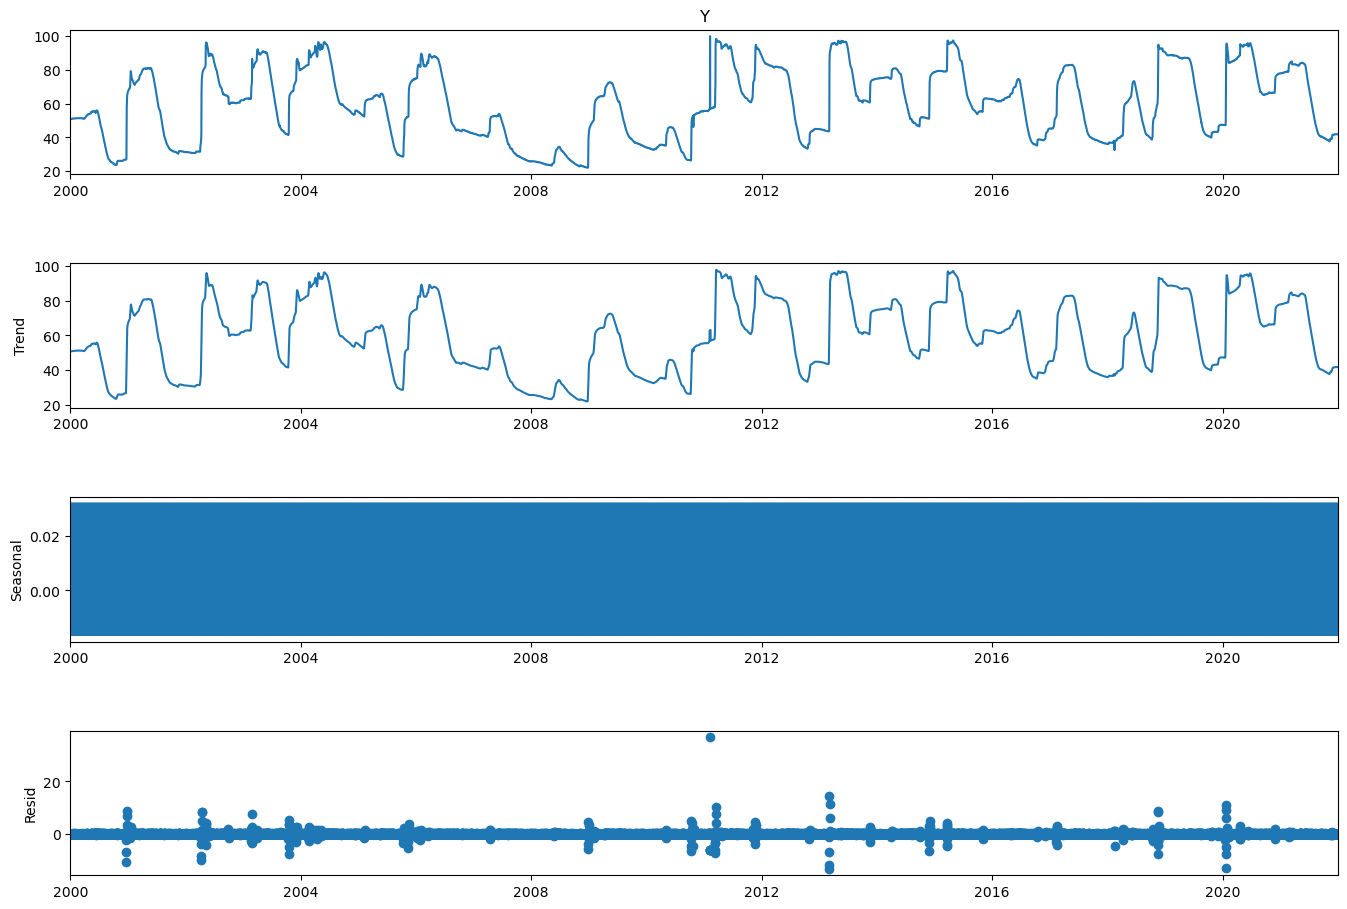

In [274]:
decomp = seasonal_decompose(df['Y'])

#change figure size 
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(15,10)

Ara ho farem en un periode d'un any.

<Figure size 640x480 with 0 Axes>

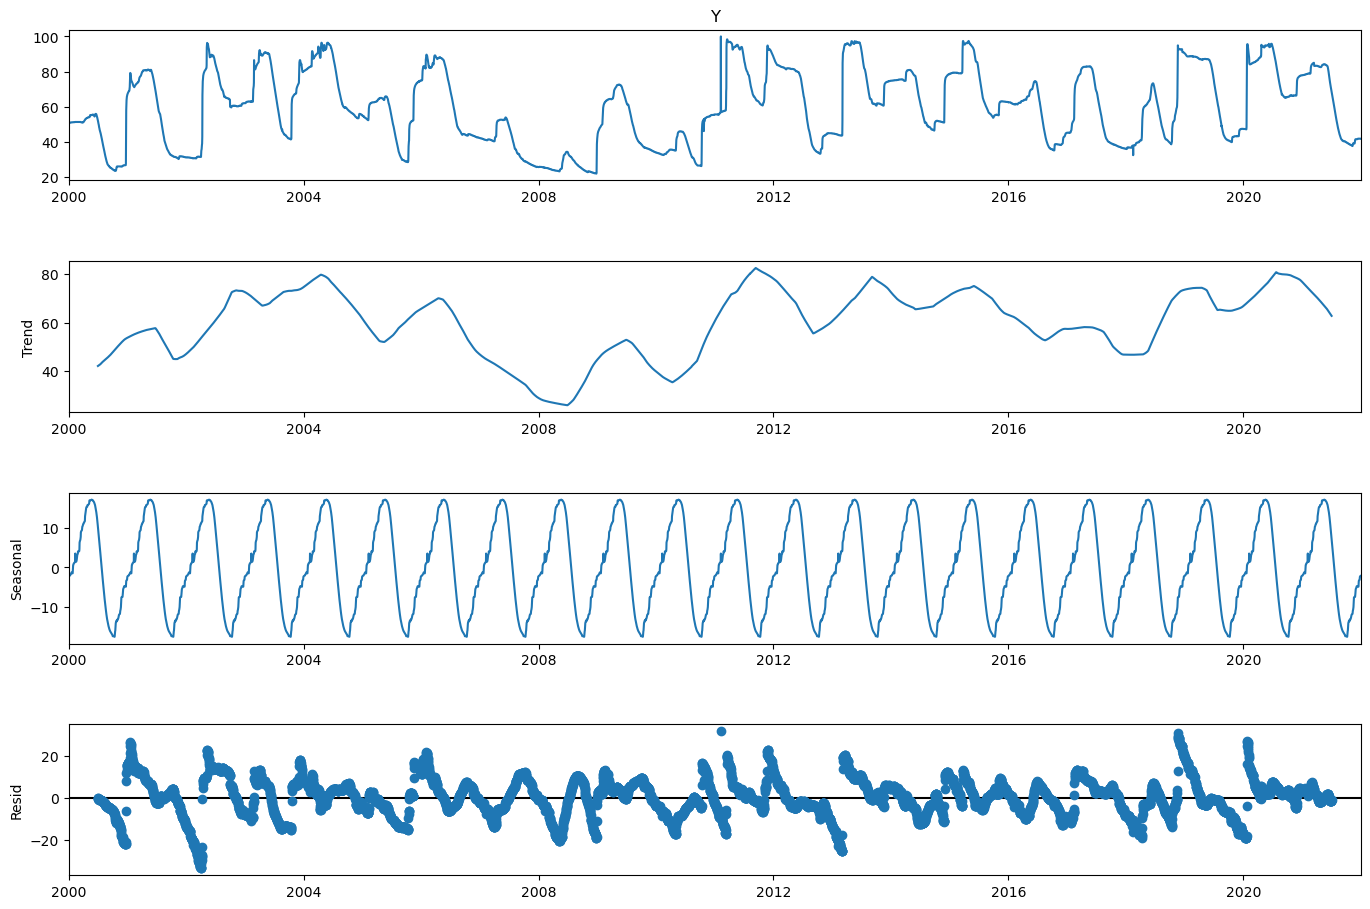

In [275]:
decomp = seasonal_decompose(df['Y'],period = 365)

#change figure size 
fig = plt.figure()
fig = decomp.plot()
fig.set_size_inches(15,10)

Com podem comprovar en les gràfiques, la serie  no té una tendencia clara i l'estacionalitat es gairebé anual. lo que ens ve a confirmar una vegada més que la serie es estacionaria.

A continuació farem una gràfica d'autocorrelació i autocorrelació parcial (acf i pacf).

/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


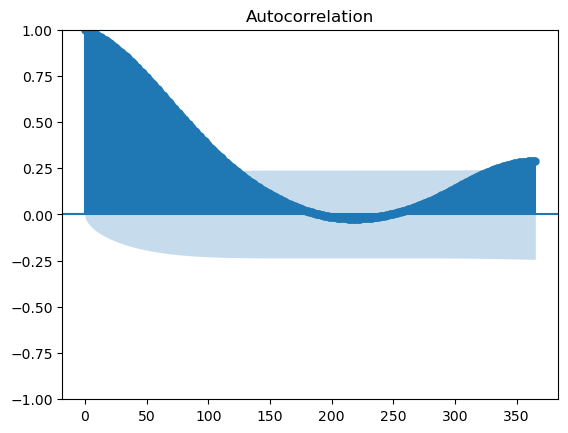

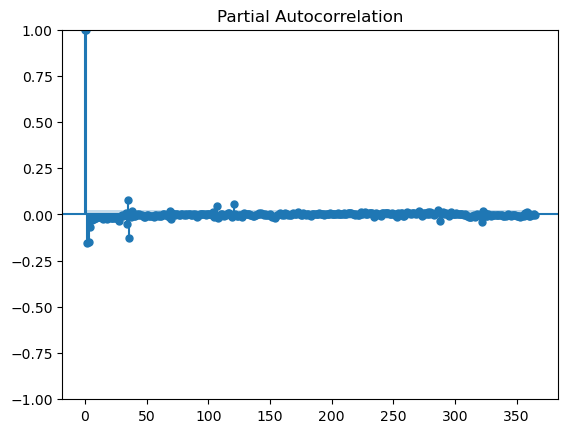

In [276]:
acf = plot_acf(df['Y'], lags=365)
pacf = plot_pacf(df['Y'], lags=365)

/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


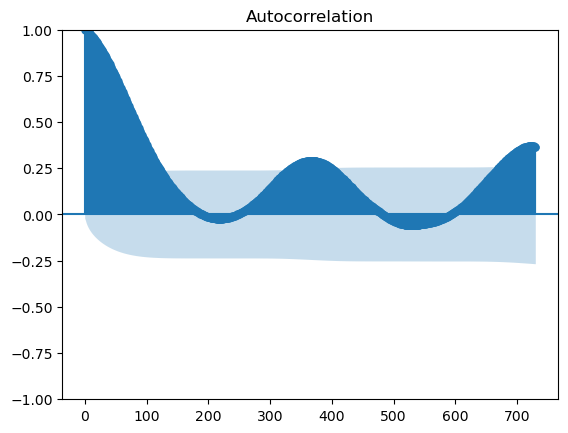

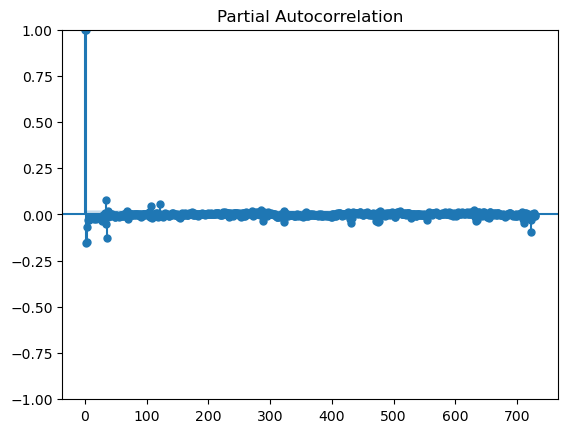

In [247]:
acf = plot_acf(df['Y'], lags=730)
pacf = plot_pacf(df['Y'], lags=730)

A continuació farem una prova estadística per comprovar l'autocorrelació de les dades.

In [237]:
acorr_ljungbox(df, lags=365, return_df=True)

,lb_stat,lb_pvalue
1,8014.847830,0.0
2,15998.582060,0.0
3,23943.489119,0.0
4,31844.680344,0.0
5,39698.790266,0.0
6,47503.021556,0.0
7,55255.039795,0.0
8,62952.993241,0.0
9,70595.125050,0.0
10,78179.998498,0.0


Aquí veiem un valor p  més petit que .01, per tant podem rebutjar la hipòtesi nul·la, indicant que la sèrie temporal conté una autocorrelació.

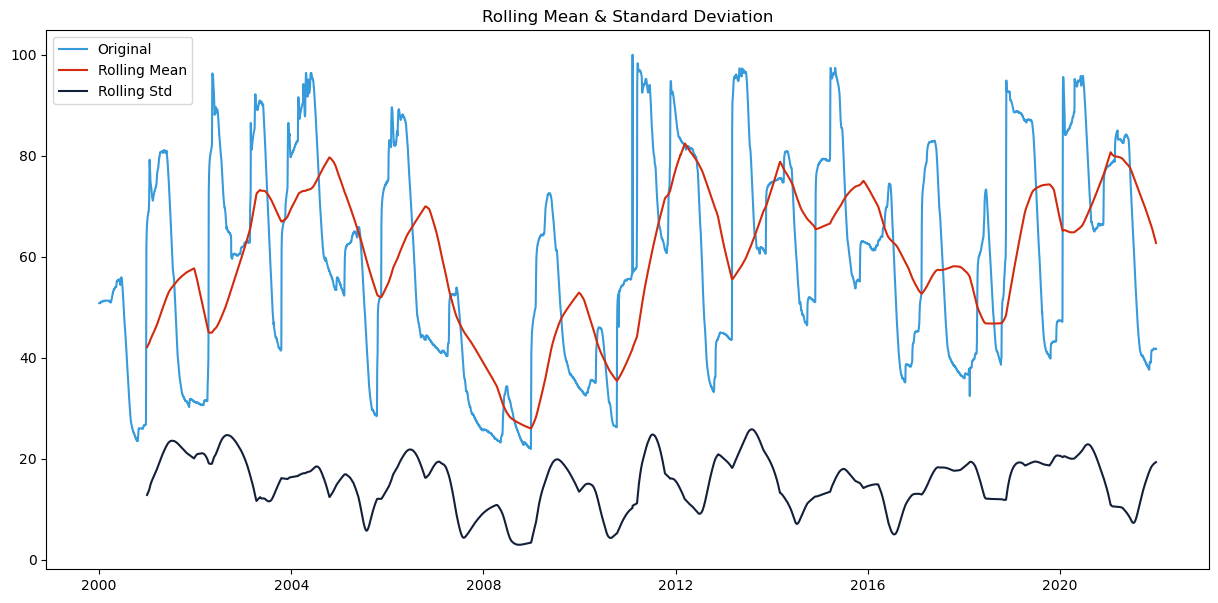

In [289]:
#Rolling mean i rolling std
rolling_avg = df["Y"].rolling(window=365).mean() 
rolling_std = df["Y"].rolling(window=365).std()

#fem la gràfica
plt.figure(figsize=(15,7))
plt.plot(df["Y"], color='#379BDB', label='Original')
plt.plot(rolling_avg, color='#D22A0D', label='Rolling Mean')
plt.plot(rolling_std, color='#142039', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

## Transformacio dades

In [138]:
df['Y'] = log(df['Y'])

In [158]:
df.head()

,Y
Dia,
2000-01-01,3.927896
2000-01-02,3.927896
2000-01-03,3.927896
2000-01-04,3.927896
2000-01-05,3.927896


In [159]:
ss = StandardScaler()

In [160]:
df_transformed2 = ss.fit_transform(df[['Y']])

In [162]:
df['Y'] = df_transformed2

In [163]:
df.head()

,Y
Dia,
2000-01-01,-0.236511
2000-01-02,-0.236511
2000-01-03,-0.236511
2000-01-04,-0.236511
2000-01-05,-0.236511


In [164]:
df.describe()

,Y
count,8.037000e+03
mean,-1.842056e-15
std,1.000062e+00
min,-2.425118e+00
25%,-7.499599e-01
50%,2.137233e-01
75%,8.955013e-01
max,1.525158e+00


In [157]:
X = df.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=3.888595, mean2=4.149019
variance1=0.168456, variance2=0.093247


In [165]:
X = df.values
split = round(len(X) / 2)
X1, X2 = X[0:split], X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=-0.338740, mean2=0.338656
variance1=1.139741, variance2=0.630890


## Model ARIMA

Separem les dades en conjunt de Train i test, amb un any de daes pel conjunt de test.

Fechas train : 2000-01-01 00:00:00 --- 2021-01-01 00:00:00  (n=7672)
Fechas test  : 2021-01-02 00:00:00 --- 2022-01-01 00:00:00  (n=365)


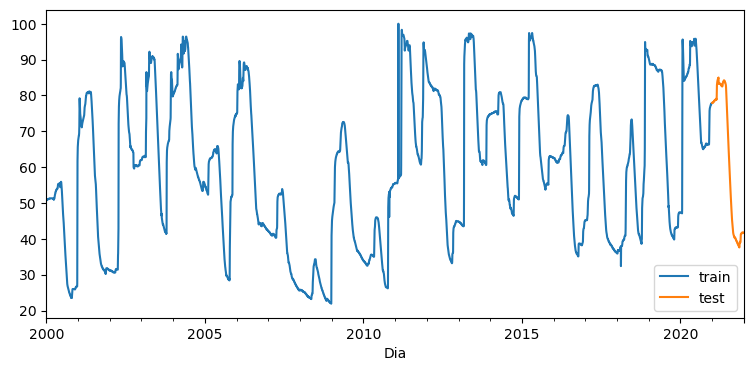

In [291]:
# Separació dades train-test
# ==============================================================================

steps = 365
train = df[:-steps]
test  = df[-steps:]

print(f"Fechas train : {train.index.min()} --- {train.index.max()}  (n={len(train)})")
print(f"Fechas test  : {test.index.min()} --- {test.index.max()}  (n={len(test)})")

# gràfica del train i test
# ==============================================================================
fig, ax = plt.subplots(figsize=(9, 4))
train['Y'].plot(ax=ax, label='train')
test['Y'].plot(ax=ax, label='test')
ax.legend();

Farem servir la funció auto_arima que ens buscarà els millor paràmetres pel nostre model ARIMA.

In [314]:
model = pm.auto_arima(train, start_p=1, start_q=1, d=None, max_d=2,
                      max_p=5, max_q=5, 
                      m=1,           
                      seasonal=False,   
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True,
                      method='bfgs')

Performing stepwise search to minimize aic


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=23840.782, Time=1.92 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=24189.337, Time=0.19 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=24034.130, Time=0.39 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=24068.972, Time=0.64 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=24187.407, Time=0.15 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=23836.454, Time=7.67 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=23879.996, Time=0.53 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1


 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=23852.877, Time=9.66 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=23834.426, Time=13.12 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=23837.594, Time=7.34 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=23838.615, Time=15.71 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=23835.174, Time=15.64 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=23832.791, Time=12.63 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=23883.208, Time=1.94 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=23826.829, Time=10.05 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=23867.791, Time=3.13 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=23831.770, Time=22.45 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,5)(0,0,0)[0] intercept   : AIC=23825.759, Time=21.19 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=23858.294, Time=4.91 sec
 ARIMA(2,1,5)(0,0,0)[0] intercept   : AIC=23830.089, Time=14.09 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,5)(0,0,0)[0]             : AIC=23823.767, Time=3.86 sec
 ARIMA(0,1,5)(0,0,0)[0]             : AIC=23856.331, Time=1.34 sec


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1


 ARIMA(1,1,4)(0,0,0)[0]             : AIC=23824.845, Time=7.18 sec
 ARIMA(2,1,5)(0,0,0)[0]             : AIC=23828.109, Time=6.37 sec
 ARIMA(0,1,4)(0,0,0)[0]             : AIC=23865.829, Time=0.97 sec
 ARIMA(2,1,4)(0,0,0)[0]             : AIC=23829.835, Time=4.24 sec

Best model:  ARIMA(1,1,5)(0,0,0)[0]          
Total fit time: 187.358 seconds


In [315]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 7672
Model:               SARIMAX(1, 1, 5)   Log Likelihood              -11904.884
Date:                Thu, 12 Jan 2023   AIC                          23823.767
Time:                        10:12:12   BIC                          23872.384
Sample:                    01-01-2000   HQIC                         23840.443
                         - 01-01-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8849      0.059     15.096      0.000       0.770       1.000
ma.L1         -0.7757      0.059    -13.205      0.000      -0.891      -0.661
ma.L2          0.0420      0.008      5.363      0.000       0.027       0.057
ma.L3         -0.0393      0.011     -3.517      0.000      -0.061      -0.017
ma.L4         -0.0192      0.015     -1.293      0.196      -0.048       0.010
ma.L5         -0.0046      0.018     -0.258      0.796      -0.039       0.030
sigma2         1.3074      0.001    963.077      0.000       1.305       1.310
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):         215456639.86
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             5.41
Prob(H) (two-sided):                  0.00   Kurtosis:                       823.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [316]:
# Forecast

prediction, confint = model.predict(n_periods=len(test), return_conf_int=True)

prediction

2021-01-02    77.906598
2021-01-03    77.912676
2021-01-04    77.918930
2021-01-05    77.924759
2021-01-06    77.929966
2021-01-07    77.934575
2021-01-08    77.938652
2021-01-09    77.942261
2021-01-10    77.945454
2021-01-11    77.948280
2021-01-12    77.950780
2021-01-13    77.952993
2021-01-14    77.954951
2021-01-15    77.956684
2021-01-16    77.958217
2021-01-17    77.959574
2021-01-18    77.960775
2021-01-19    77.961837
2021-01-20    77.962778
2021-01-21    77.963610
2021-01-22    77.964346
2021-01-23    77.964997
2021-01-24    77.965574
2021-01-25    77.966084
2021-01-26    77.966535
2021-01-27    77.966935
2021-01-28    77.967289
2021-01-29    77.967601
2021-01-30    77.967878
2021-01-31    77.968123
2021-02-01    77.968340
2021-02-02    77.968532
2021-02-03    77.968702
2021-02-04    77.968852
2021-02-05    77.968985
2021-02-06    77.969102
2021-02-07    77.969206
2021-02-08    77.969299
2021-02-09    77.969380
2021-02-10    77.969452
2021-02-11    77.969516
2021-02-12    77

In [295]:
cf= pd.DataFrame(confint)

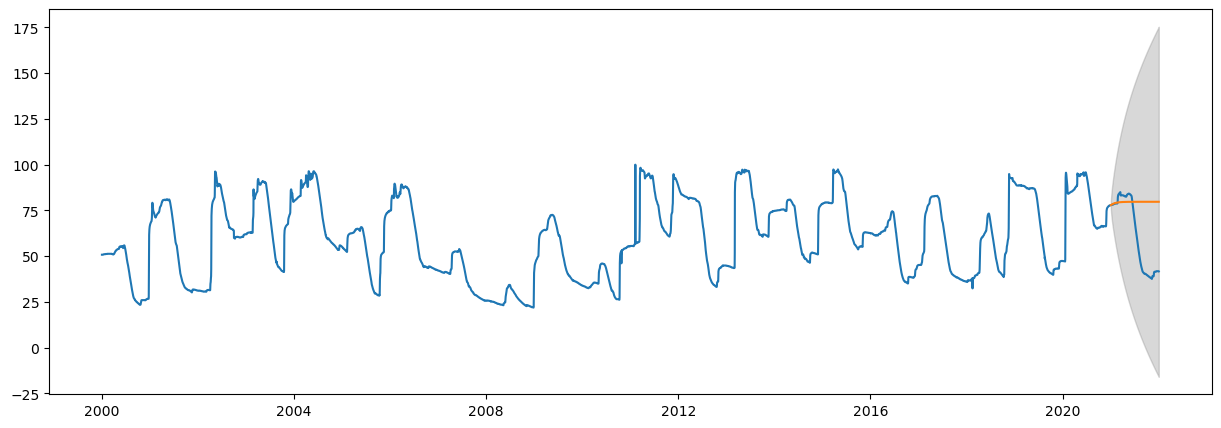

In [296]:
#Fem la gràfica amb la predicció de l'ultim any en taronja sobre la serie real.
prediction_series = pd.Series(prediction,index=test.index)
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(df)
ax.plot(prediction_series)
ax.fill_between(prediction_series.index,
                cf[0],
                cf[1],color='grey',alpha=.3)

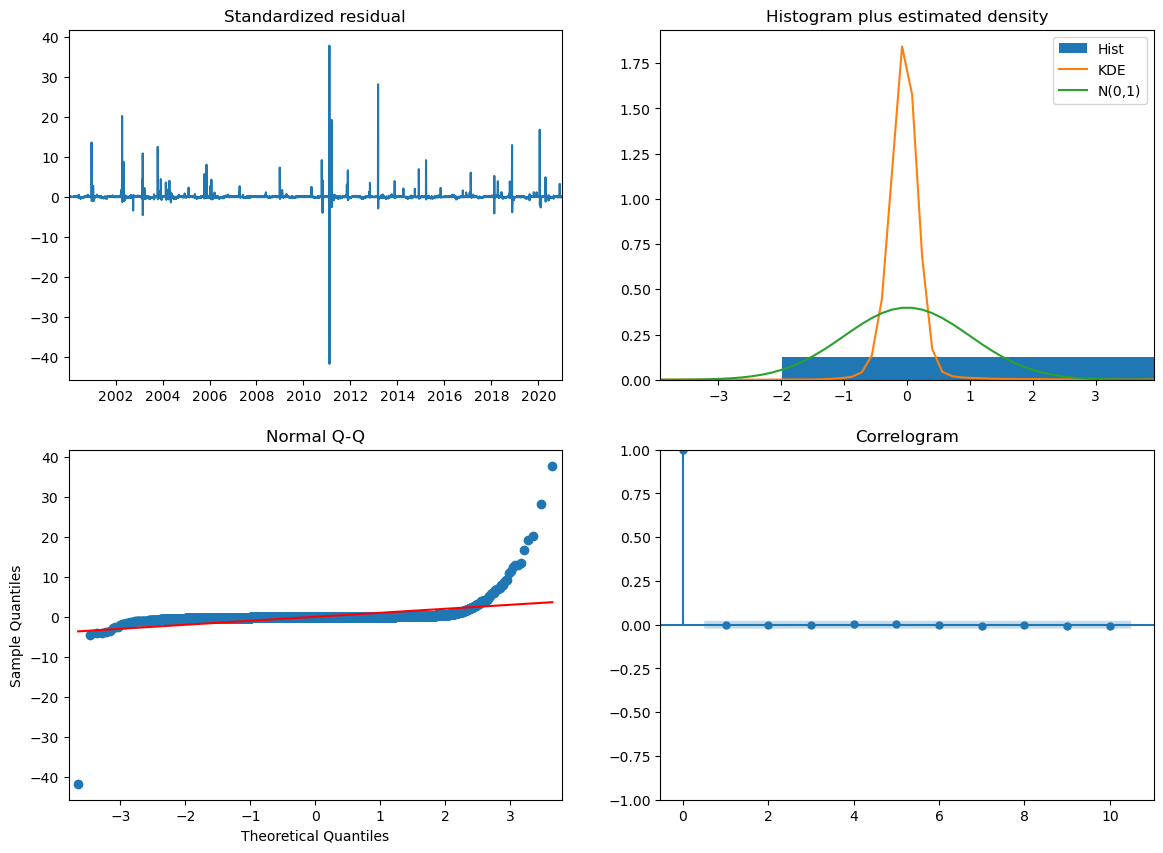

In [287]:
model.plot_diagnostics(figsize=(14,10))
plt.show()

In [38]:
serie_a_predecir = y_log

y_index = serie_a_predecir.index

date_train = int(len(y_index)*0.9)

y_train = serie_a_predecir[y_index[:date_train]]
y_test = serie_a_predecir[y_index[date_train:len(y_index)]]

In [39]:
y_train.tail()

Dia
2020-08-22    4.235555
2020-08-23    4.229749
2020-08-24    4.223910
2020-08-25    4.219508
2020-08-26    4.213608
Freq: D, Name: Y_log, dtype: float64

In [40]:
y_test.head()

Dia
2020-08-27    4.201703
2020-08-28    4.203199
2020-08-29    4.203199
2020-08-30    4.203199
2020-08-31    4.201703
Freq: D, Name: Y_log, dtype: float64

In [43]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

seasonal_pdq = [(0, 0, 0, 0)]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[0]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[0]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 0, 0)
SARIMAX: (0, 1, 0) x (0, 0, 0, 0)


In [75]:
my_order = (2, 0, 1)
my_seasonal_order = (2, 1, 0, 365)
# define model
model = SARIMAX(y_train, order=my_order, seasonal_order=my_seasonal_order)

In [ ]:
results = model.fit()

print(results.summary().tables[1])

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.26534D+00    |proj g|=  1.03075D+01


In [72]:
results.aic

-36748.25133544558

In [67]:
# Para hacer una predicción es suficiente con especificar el número de steps/pasos futuros a estimar.
pred_uc = results.get_forecast(steps = len(y_test))

# Calcula el intervalo de confianza de la predicción.
pred_ci = pred_uc.conf_int()

In [60]:
print(len(y_test))

839


In [71]:
pred_ci

,lower Y_log,upper Y_log
2020-08-27,4.170358,4.252953
2020-08-28,4.144528,4.274249
2020-08-29,4.124417,4.290549
2020-08-30,4.107331,4.302700
2020-08-31,4.093157,4.312738
2020-09-01,4.080563,4.320682
2020-09-02,4.069716,4.327582
2020-09-03,4.059717,4.333128
2020-09-04,4.049974,4.337146
2020-09-05,4.041263,4.340716


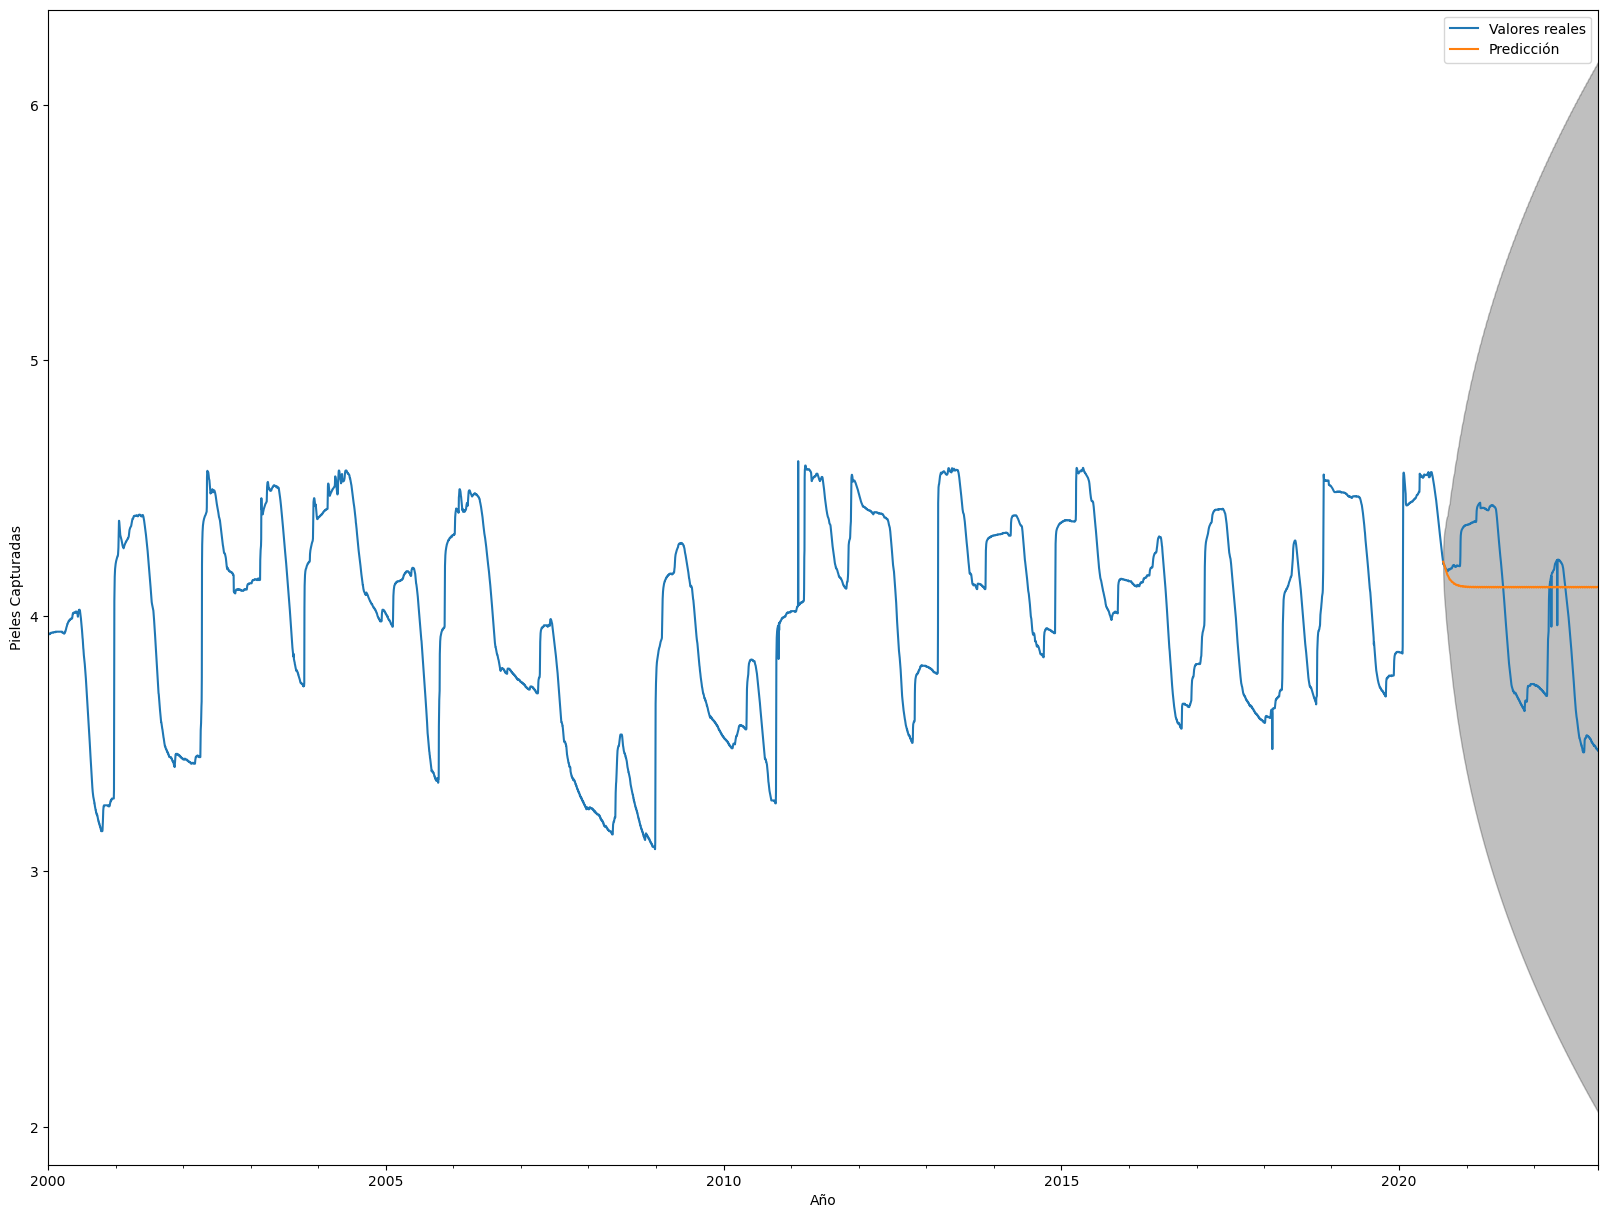

In [68]:
ax = serie_a_predecir.plot(label = 'Valores reales', figsize = (20, 15))

pred_uc.predicted_mean.plot(ax = ax, label = 'Predicción')

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color = 'k', alpha = .25)

ax.set_xlabel('Año')
ax.set_ylabel('Pieles Capturadas')

plt.legend()
plt.show()

In [44]:
st = time.time()

best_score = 0
best_params = None
best_seasonal_params = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            mod = sm.tsa.statespace.SARIMAX(y_train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            # guardamos el mejor resultado
            if best_score == 0:
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
                
            elif abs(results.aic) < abs(best_score):
                best_score = results.aic
                best_params = param
                best_seasonal_params = param_seasonal
            
        # alguna combinación de parámetros en SARIMAX, no son válidos
        # y los vamos a cazar con un except
        except:
            continue

et = time.time()

print("La búsqueda de parámetros no ha llevado {} minutos!".format((et - st)/60))

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.81251D+00    |proj g|=  1.04086D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.041D-06   2.813D+00
  F =   2.8125106444078005     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA(0, 0, 0)x(0, 0, 0, 0)12 - AIC:42437.16060282489
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables

 This problem is unconstrained.



At iterate    5    f=  1.72124D+00    |proj g|=  9.39070D-01

At iterate   10    f=  1.51379D+00    |proj g|=  2.26282D+00

At iterate   15    f=  1.46940D+00    |proj g|=  1.12006D+00

At iterate   20    f=  1.46137D+00    |proj g|=  7.21488D-02

At iterate   25    f=  1.46105D+00    |proj g|=  2.08838D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     56      1     0     0   1.960D-04   1.461D+00
  F =   1.4610346943940393     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 0, 2)x(0, 0, 0, 0)12 - AIC:22050.091469017265
RUNNING THE L-BFGS-B CODE

           * * *

Machine preci

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1     18      1     0     0   1.334D-02  -2.534D+00
  F =  -2.5341512581960428     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 0)x(0, 0, 0, 0)12 - AIC:-38233.274183661895
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.56354D+00    |proj g|=  4.68289D-01

At iterate    5    f= -2.56358D+00    |proj g|=  3.35419D-01

At iterate   10    f= -2.56371D+00    |proj g|=  3.00128D-02

           * 

 This problem is unconstrained.



At iterate    5    f= -2.57259D+00    |proj g|=  3.10955D-01

At iterate   10    f= -2.57272D+00    |proj g|=  4.61083D-02

At iterate   15    f= -2.57272D+00    |proj g|=  3.15612D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     39      1     0     0   3.156D-03  -2.573D+00
  F =  -2.5727226040242170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 1, 2)x(0, 0, 0, 0)12 - AIC:-38811.238649517385
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.34432D+00    |proj g|=  1.43900D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate    5    f= -2.52506D+00    |proj g|=  4.02877D+00

At iterate   10    f= -2.55450D+00    |proj g|=  2.53400D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     34      1     0     0   1.035D-03  -2.555D+00
  F =  -2.5547672037755178     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(0, 2, 1)x(0, 0, 0, 0)12 - AIC:-38542.327570565016
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.54516D+00    |proj g|=  1.85330D+00

At iterate    5    f= -2.54855D+00    |proj g|=  5.03094D+00

At iterate   10    f= -2.57030D+00    |proj g|=  2.35474D-01

At iterate   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     18      1     0     0   2.208D-01  -2.535D+00
  F =  -2.5345536373173592     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 0)x(0, 0, 0, 0)12 - AIC:-38237.34527984432
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.56383D+00    |proj g|=  2.89752D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -2.56384D+00    |proj g|=  7.60446D-02

At iterate   10    f= -2.56391D+00    |proj g|=  1.15398D+00

At iterate   15    f= -2.56412D+00    |proj g|=  1.17093D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     35      1     0     0   6.556D-04  -2.564D+00
  F =  -2.5641162622831972     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 1)x(0, 0, 0, 0)12 - AIC:-38681.38616532888
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f= -2.57296D+00    |proj g|=  8.88101D-02

At iterate   10    f= -2.57311D+00    |proj g|=  4.82366D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     25      1     0     0   2.542D-02  -2.573D+00
  F =  -2.5731256108882099     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 0, 2)x(0, 0, 0, 0)12 - AIC:-38815.31921708131
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.57186D+00    |proj g|=  2.92522D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     19      1     0     0   2.927D-02  -2.572D+00
  F =  -2.5718648214891751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 0)x(0, 0, 0, 0)12 - AIC:-38800.29642662867
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.57957D+00    |proj g|=  1.31102D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2     22      1     0     0   2.450D-02  -2.580D+00
  F =  -2.5795666204164753     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 1, 1)x(0, 0, 0, 0)12 - AIC:-38914.50116884378
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.57950D+00    |proj g|=  9.24012D-02

At iterate    5    f= -2.57950D+00    |proj g|=  5.81063D-02

At iterate   10    f= -2.57951D+00    |proj g|=  5.26198D-02

           * *


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   2.321D-02  -2.449D+00
  F =  -2.4494078001473247     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(1, 2, 0)x(0, 0, 0, 0)12 - AIC:-36952.664888622836
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.53120D+00    |proj g|=  2.73595D+00

At iterate    5    f= -2.53226D+00    |proj g|=  1.34518D+00

At iterate   10    f= -2.54840D+00    |proj g|=  6.70973D+00

At iterate   

 This problem is unconstrained.



At iterate    5    f= -2.54093D+00    |proj g|=  3.22418D+00

At iterate   10    f= -2.55761D+00    |proj g|=  1.62495D-01

At iterate   15    f= -2.55981D+00    |proj g|=  1.99650D+00

At iterate   20    f= -2.56081D+00    |proj g|=  6.87403D-03

At iterate   25    f= -2.56126D+00    |proj g|=  7.39373D-01

At iterate   30    f= -2.57310D+00    |proj g|=  5.51576D+00

At iterate   35    f= -2.57686D+00    |proj g|=  6.36273D-01

At iterate   40    f= -2.57813D+00    |proj g|=  5.26022D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44    102      2     0     0   7.659D-04  -2.578D+00
  F =  -2.5781297701657575     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(1, 2, 2)x(0, 0, 0, 0)12 - AIC:-38890.82197226095
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.57187D+00    |proj g|=  2.37999D-01


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     21      1     0     0   2.380D-01  -2.572D+00
  F =  -2.5718661598279651     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 0)x(0, 0, 0, 0)12 - AIC:-38798.316619484336
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.57991D+00    |proj g|=  7.11435D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explor

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      1     10      1     0     0   8.572D-01  -2.580D+00
  F =  -2.5798208611619931     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 0, 2)x(0, 0, 0, 0)12 - AIC:-38914.33715321215
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.57762D+00    |proj g|=  2.96244D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     11      1     0     0   2.943D-02  -2.578D+00
  F =  -2.5776164341577488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 0)x(0, 0, 0, 0)12 - AIC:-38885.07675857211
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.57961D+00    |proj g|=  1.37468D-01


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      2     18      1     0     0   1.480D-02  -2.580D+00
  F =  -2.5796154327492884     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA(2, 1, 1)x(0, 0, 0, 0)12 - AIC:-38913.237649321265
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.57945D+00    |proj g|=  8.73198D-02

At iterate    5    f= -2.57946D+00    |proj g|=  1.58675D-01

At iterate   10    f= -2.57947D+00    |proj g|=  7.14037D-02

At iterate   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.48496D+00    |proj g|=  2.46777D-02


/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     21      1     0     0   2.468D-02  -2.485D+00
  F =  -2.4849628056273141     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA(2, 2, 0)x(0, 0, 0, 0)12 - AIC:-37487.118811304914
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.53657D+00    |proj g|=  3.25826D+00

At iterate    5    f= -2.54165D+00    |proj g|=  4.99928D+00

At iterate   10    f= -2.56371D+00    |proj g|=  8.63222D-02

At iterate   

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.54878D+00    |proj g|=  1.64304D+00

At iterate    5    f= -2.54928D+00    |proj g|=  1.23348D+00

At iterate   10    f= -2.55871D+00    |proj g|=  3.47679D+00

At iterate   15    f= -2.56862D+00    |proj g|=  4.57782D-01

At iterate   20    f= -2.57207D+00    |proj g|=  9.55058D-01

At iterate   25    f= -2.57423D+00    |proj g|=  2.21569D-03

At iterate   30    f= -2.57425D+00    |proj g|=  7.10444D-02

At iterate   35    f= -2.57533D+00    |proj g|=  3.73783D-01

At iterate   40    f= -2.57618D+00    |proj g|=  4.57716D-02

At iterate   45    f= -2.57838D+00    |proj g|=  6.31689D-01

At iterate   50    f= -2.57865D+00    |proj g|=  4.53961D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates s

/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [45]:
print("El mejor modelo es {}, \nCon un AIC de {}".format(best_params, best_score))

El mejor modelo es (0, 0, 2), 
Con un AIC de 22050.091469017265


In [197]:
forecaster = AutoARIMA(sp=12, d=0, max_p=2, max_q=2, suppress_warnings=True)
forecaster.fit(df)

/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1906: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ma)**-1
/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
/Users/david/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.po

AutoARIMA(d=0, max_p=2, max_q=2, sp=12, suppress_warnings=True)

In [198]:
forecaster.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 8037
Model:             SARIMAX(2, 0, 2)x(0, 0, 2, 12)   Log Likelihood               13311.303
Date:                            Tue, 10 Jan 2023   AIC                         -26608.605
Time:                                    22:50:30   BIC                         -26559.662
Sample:                                01-01-2000   HQIC                        -26591.857
                                     - 01-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.7914      0.024     75.682      0.000       1.745       1.838
ar.L2         -0.7924      0.024    -33.580      0.000      -0.839      -0.746
ma.L1         -0.5634      0.024    -23.588      0.000      -0.610      -0.517
ma.L2         -0.0507      0.008     -6.280      0.000      -0.066      -0.035
ma.S.L12       0.0022      0.020      0.110      0.913      -0.036       0.041
ma.S.L24       0.0181      0.019      0.963      0.336      -0.019       0.055
sigma2         0.0021   2.88e-06    740.294      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):         124729343.62
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             6.45
Prob(H) (two-sided):                  0.00   Kurtosis:                       613.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""